##### Recharge Me

## Model Description 
This intially constructs the 3D (homogeneous) steady state box model that you built for your BoxModel_Manual assignment

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 100 m
- dz = 100 m  

#### Subsurface Properties: 
- Homogeneous 
- K = 1.0 m/day in x, y and z 
- Porosity = 0.35
- Specific yield = 0.3
- Storage coefficient=0.001  

#### Boundary Conditions: 
 - Right boundary is a constant head of 30 m relative to the datum, which is located at the bottom of the domain.
 - Left boundary is a constant head of 50 m relative to the datum, which is located at the bottom of the domain. 
 - Recharge occurs at a rate of 1E-5 m/d uniformly across the domain
 - There is no ET in the domain

#### Initial Conditions: 
 - Set the initial head to 30 everywhere, which will be replaced by the steady state solution

#### Pumping
 - Well located at row, column 20,20
     - There is no pumping during the initial steady state period
     - Case 1: pumps at a rate of 500 m3/d for 90 days, then zero for remaining 270 days of the year for 100 years. (Assume a 360 day year made of 12 30-day months for simplicity of plotting.)
     - Case 2: one 'equivalent' constant pumping rate for 100 years.


## 1. Setup the environment

In [46]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#jupyter specific--included to show plots in notebook
%matplotlib inline 

## 2. Create the model object

In [47]:
modelname = "Transient"
moddir="D:/tyferre/frequent/GitHub/Git_GW_Modeling_Spring2021/Course_Materials/Assignments/mf2005"
moddir="C:/Users/tyfer\Documents/frequent/GitHub/Git_GW_Modeling_Spring2021/Course_Materials/Assignments/mf2005"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)


In [48]:
#optional delete old run files
run = 'n'
if run == 'y':
    # file_extensions = ['.dis','.bas','.lpf','.oc','.pcg','.wel']
    file_extensions = ['.dis','.bas','.bcf','.oc','.pcg', '.wel', 'rch','evt']
    for ext in file_extensions:
        os.remove(modelname + ext)

## 3. Setup the discretization (DIS package)

For more details on DIS package inputs refer to : https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfdis.html 

#### 3.1 Spatial discretization

In [49]:
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 1  #number of layers

dx= 100 #width of grid cells in x direction 
dy= 100 #width of grid cells in y direction 

Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y
ztop = 100.    #top elevation 
zbot = 0.     #bottom elevation

dz = (ztop - zbot) / nlay #cell height in z direction

domain_centerpt = (0, int(nrow/2), int(ncol/2))

#### 3.2 Temporal discretization 

In [50]:
sp_peryr = 2        # periods for seasonality (two stress periods per year)
sp1_len = 90       # Length of stress period 1 in days
sp2_len = 360-sp1_len     # Length of stress period 2 in days
sim_years = 100       #number of years for transient simulation 
nper = int(sp_peryr*sim_years + 1) # total number of stress periods the +1 is for the steady state start

#setup the steady state array
steady = np.ones(nper, dtype=bool)*False     # steady-state or transient flag for each stress period (boolean array)
#print(steady)
steady[0] = True    # initial stress period is steady-state

#make an array of period lengths
perlen=np.tile([sp1_len, sp2_len],sim_years)
perlen=np.append(10,perlen) #add a period of length 10 at the start for the steady state simulation
print("Period lengths", perlen)

#make an nstp array for the # of time steps to solve within each period in this case we will do daily 
#so we can repeat the perlen array
nstp=perlen/30 # set monthly time steps per stress period to get monthly results
nstp[0]=1 #for the steady state solution we just want one output
nstp = nstp.astype(int)

elyears = (np.cumsum(perlen)-perlen[0])/360


Period lengths [ 10  90 270  90 270  90 270  90 270  90 270  90 270  90 270  90 270  90
 270  90 270  90 270  90 270  90 270  90 270  90 270  90 270  90 270  90
 270  90 270  90 270  90 270  90 270  90 270  90 270  90 270  90 270  90
 270  90 270  90 270  90 270  90 270  90 270  90 270  90 270  90 270  90
 270  90 270  90 270  90 270  90 270  90 270  90 270  90 270  90 270  90
 270  90 270  90 270  90 270  90 270  90 270  90 270  90 270  90 270  90
 270  90 270  90 270  90 270  90 270  90 270  90 270  90 270  90 270  90
 270  90 270  90 270  90 270  90 270  90 270  90 270  90 270  90 270  90
 270  90 270  90 270  90 270  90 270  90 270  90 270  90 270  90 270  90
 270  90 270  90 270  90 270  90 270  90 270  90 270  90 270  90 270  90
 270  90 270  90 270  90 270  90 270  90 270  90 270  90 270  90 270  90
 270  90 270]


#### 3.3 Create DIS object

In [51]:
#create flopy discretization object, length and time are meters (2) and days (4)
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

#### 3.4 Plot the grid

For help on this function see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.plot.plotutil.html

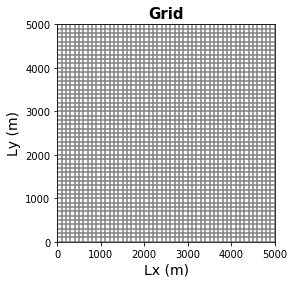

In [52]:
#use flopy to plot the grid of model 'm'
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid() 
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Grid', fontsize = 15, fontweight = 'bold')
plt.show()

## 4. Setup constant head boundaries, active cells and initial heads (BAS Package)

For more details on the BAS package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfbas.html

#### 4.1 Define cell activity: IBOUND 

In [53]:
#create ibound as array of ints = 1
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active     

#set constant head boundary on the left
ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head 
ibound[:,:,-1] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head 


#### 4.2 Define starting heads 

In [55]:
#setup initial heads as 70 everywhere, this value will be preserved on constant head boundaries  
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = 50    # set all values to uniform initial condition
H_init[:, :, -1] = 30    #replace last (right) col with desired head value


#### 4.3 Create BAS object

In [56]:
#create flopy bas object
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#### 4.4 Plot the grid and ibound

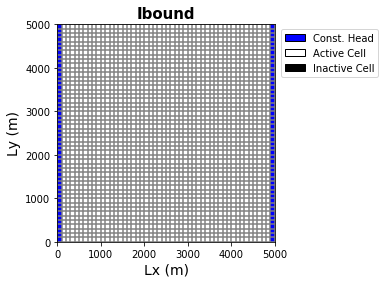

In [57]:
#plot grid and ibound
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.5,1.0))
plt.show(modelmap)


# I'm not sure why this stopped working!  Can someone figure out why the right boundary doesn't show up as constant head??

## 5. Setup Layer Properties  (LPF Package)

For more details on LPF package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mflpf.html

#### 5.1 Set layer properties

In [58]:
# K_horiz = 1.    #horizontal hydraulic conductivity 
# K_vert = 1    #assign vertical hydraulic conductivity (along z axis)
# n = 0.35        #assign porosity
# Ss = 0.001      #assign storage coefficient
# Sy = 0.3        #assign specific yield
# uncnf = 1       #0=confined, >0 = unconfined

#### 5.2 Make LPF object

In [59]:
# kept in case you want to use it later

#assigns horizontal and vertical Ks and saves cell-by-cell budget data
# lpf = flopy.modflow.ModflowLpf(m, laytyp=uncnf, hk=K_horiz, 
#                                vka=K_vert, ss=Ss,
#                                sy=Sy,storagecoefficient=True, ipakcb=53) 


## 5b. Setup Cell-byCell Properties  (BCF Package)

For more details on LPF package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfbcf.html

#### 5b.1 Set cell properties and show K in top layer

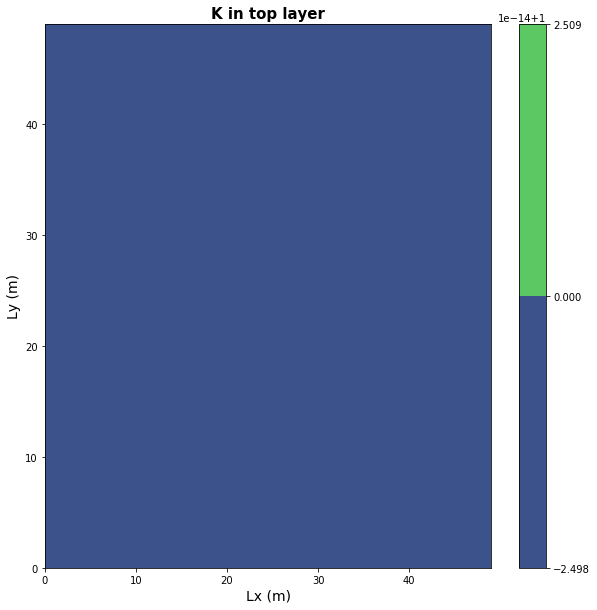

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [60]:
K_vals = np.zeros((ncol,nrow,nlay))
K_vals[:,:,:] = 1             # homoogeneous background hydraulic conductivity 
#K_vals[10:15,10:15,:] = 0.1   # low K inclusion

n = 0.35        #assign porosity
Ss = 0.001      #assign storage coefficient
Sy = 0.3        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

#plot K values in top layer
fig1 = plt.figure(figsize=(10,10)) #create 10 x 10 figure
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('K in top layer', fontsize = 15, fontweight = 'bold')
plt.contourf(K_vals[:,:,0])
plt.colorbar()
plt.show()

print(K_vals[:,:,0])

#### 5b.2 Make BCF object

In [61]:
#assigns horizontal and vertical Ks and saves cell-by-cell budget data
bcf = flopy.modflow.ModflowBcf(m, ipakcb=53, intercellt=0, laycon=3, trpy=1.0, hdry=-1e+30, iwdflg=0, wetfct=0.1, iwetit=1, ihdwet=0, tran=1.0, hy=K_vals[:,:,0], vcont=1.0, sf1=Ss, sf2=Sy, wetdry=-0.01, extension='bcf', unitnumber=None, filenames=None) 


## 6. Setup outputs by stress period (OC Package)
For more details on OC Package: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfoc.html

#### 6.1 Setup outputs

In [62]:
#create oc stress period data - save for each time step in each stress period. 
oc_spd = {}
for kper in range(nper):  
    for kstp in range(nstp[kper]):
        #print(kstp)
        oc_spd[(kper, kstp)] = ['save head','save drawdown','save budget','print head','print budget']
# print("oc stress period data: \n", oc_spd)


#### 6.2 Make OC object 

In [63]:
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)

## 7. Set the numerical solver (PCG Package)

We are using the Preconditioned Conjugate Gradient package:

Additionally, MODFLOW online describes these solvers: https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html?oc.htm

And Flopy documents its communication with the PCG MODFLOW package: http://modflowpy.github.io/flopydoc/mfpcg.html

#### 7.1 Make the PCG object

In [64]:
pcg = flopy.modflow.ModflowPcg(model=m)

## 8. Add wells for the constant flux boundary (WEL Package)
For more details on the WEL package see: http://modflowpy.github.io/flopydoc/mfwel.html

#### 8.1 Setup the well parameters (use this to set a defined flux boundary)

In [77]:
#Setup alternating pumping values
well_loc = [0, 20, 20]
Q1 = -500
Q2 = 0
Q_val=np.tile([Q1, Q2],sim_years)
Q_val=np.append(0,Q_val) # add a period of length 10 at the start for the steady state simulation
                      
Q = {}
for p in range(0,nper):    #loop over stress periods
    Q[p]=Q_val[p]

well_spd = {}                                                                                                     # create empty dictionary for well info
for per in range(nper):                                                                                       # transient models, iterate over stress periods to assign well stresses
    well_spd[per] = [[well_loc[0], well_loc[1], well_loc[2], Q_val[per]]]     # assign well coord & pump rate for each stress period

print(well_spd)

{0: [[0, 20, 20, 0]], 1: [[0, 20, 20, -500]], 2: [[0, 20, 20, 0]], 3: [[0, 20, 20, -500]], 4: [[0, 20, 20, 0]], 5: [[0, 20, 20, -500]], 6: [[0, 20, 20, 0]], 7: [[0, 20, 20, -500]], 8: [[0, 20, 20, 0]], 9: [[0, 20, 20, -500]], 10: [[0, 20, 20, 0]], 11: [[0, 20, 20, -500]], 12: [[0, 20, 20, 0]], 13: [[0, 20, 20, -500]], 14: [[0, 20, 20, 0]], 15: [[0, 20, 20, -500]], 16: [[0, 20, 20, 0]], 17: [[0, 20, 20, -500]], 18: [[0, 20, 20, 0]], 19: [[0, 20, 20, -500]], 20: [[0, 20, 20, 0]], 21: [[0, 20, 20, -500]], 22: [[0, 20, 20, 0]], 23: [[0, 20, 20, -500]], 24: [[0, 20, 20, 0]], 25: [[0, 20, 20, -500]], 26: [[0, 20, 20, 0]], 27: [[0, 20, 20, -500]], 28: [[0, 20, 20, 0]], 29: [[0, 20, 20, -500]], 30: [[0, 20, 20, 0]], 31: [[0, 20, 20, -500]], 32: [[0, 20, 20, 0]], 33: [[0, 20, 20, -500]], 34: [[0, 20, 20, 0]], 35: [[0, 20, 20, -500]], 36: [[0, 20, 20, 0]], 37: [[0, 20, 20, -500]], 38: [[0, 20, 20, 0]], 39: [[0, 20, 20, -500]], 40: [[0, 20, 20, 0]], 41: [[0, 20, 20, -500]], 42: [[0, 20, 20, 0]], 

#### 8.2 Make the WEL object

In [78]:
wel = flopy.modflow.mfwel.ModflowWel(m, stress_period_data=well_spd)  #create object for WEL package

##9. Add recharge (RCH Package)

For more details on the WEL package see: http://modflowpy.github.io/flopydoc/mfrch.html

#### 9.1 Setup recharge value

In [79]:
#Recharge 
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol) - backgroun ET is zero everywhere
recharge = 1e-4 #m/day                          
rech_zone[:,:] = recharge

rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone, ipakcb=53)     #create rch object


9.2 Add evapotranspiration

In [80]:
# ET - this is set up to show how you would add time-varying recharge in a localized area
ET_val1 = 0 #m/day
ET_val2 = 0 #m/day
ET_locxy=[[400, 900], [1500, 1600]] #lower left and upper right corners of ET in xy coordinate
extinction_depth = 50

ET_rows=(np.floor(nrow-ET_locxy[1][1]/dy),np.floor(nrow-ET_locxy[0][1]/dy)) #convert the y locations to rows
ET_cols=(np.floor(ET_locxy[0][0]/dx),np.floor(ET_locxy[1][0]/dx)) #convert the y locations to rows
ET_centerpt=(0, int(np.mean(ET_rows)),int(np.mean(ET_cols)))
ET_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(ET_rows[0]):int(ET_rows[1]), int(ET_cols[0]):int(ET_cols[1])] = ET_val2  # assign ET rate to the ET zone

#Setup alternating ET values
ET_val=np.tile([ET_val1, ET_val2],sim_years)
ET_val=np.append(ET_val1,ET_val) # add a period of length 10 at the start for the steady state simulation
print('ET_val',ET_val)
                      
ET = {}
for p in range(0,nper):    #loop over stress periods
    ET[p]=ET_zone*ET_val[p]

evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET, exdp=extinction_depth, ipakcb=53) 



ET_val [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## 10. Write inputs and run the model 

#### 10.1 Write Inputs

In [81]:
m.write_input()    #uses the package objects created above to actually write the text files, 
                    #and saves to folder that this script is in
                    #after this step you should see the files appear in your folder


#### 10.2 Run the model

In [82]:
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following  executable to run the model: C:/Users/tyfer\Documents/frequent/GitHub/Git_GW_Modeling_Spring2021/Course_Materials/Assignments/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: Transient.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2021/03/18 12:19:06

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     1   

 Solving:  Stress period:   113    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:     1    Ground-Wa

## 11. Plot the results  

#### 11.1 Read in the model outputs

For information on binary files see: http://modflowpy.github.io/flopydoc/binaryfile.html 

For information on flow budget files see: 
http://modflowpy.github.io/flopydoc/binaryfile.html#flopy.utils.binaryfile.CellBudgetFile



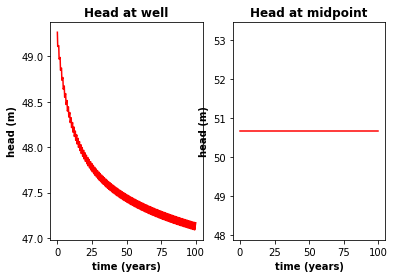

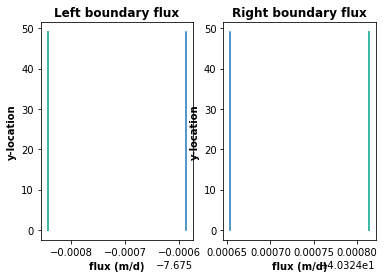

In [84]:
# Read the heads 
# headobj = bf.HeadFile(modelname+'.hds')    #reads the binary head file
# times = headobj.get_times()                #returns a list of timesteps
# head = headobj.get_data(totim=times[-1])   #returns a numpy array of heads for specified time (last timestep)

# head = headobj.get_data

hds = bf.HeadFile(modelname+'.hds')                   # reads the binary head file
times = hds.get_times() # returns a list of timesteps

#extract binary data from head file
head = {} #create dictionary to store head data at end of each stress period
frf = {} #create dictionary to store flows through right cell face at end of each stress period
fff = {} #create dictionary to store flows through front cell face at end of each stress period
headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds') #get head data as python object
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc') #get flow data as python object

#get data from python objects
head = []
headarray=np.zeros((len(times),ncol,nrow))
frf=np.zeros((len(times),ncol,nrow))
fff=np.zeros((len(times),ncol,nrow))
rowcounter=-1
for i in times:
    rowcounter+=1
    temphead = headobj.get_data(totim=i) #append heads to head list for each stress per
    headarray[rowcounter,:,:] = temphead
    tempfrf = np.squeeze(budgobj.get_data(text='flow right face',totim=i))
    # print(tempfrf)
    frf[rowcounter,:,:] = tempfrf
    tempfff = np.squeeze(budgobj.get_data(text='FLOW FRONT FACE',totim=i))
    fff[rowcounter,:,:] = tempfff


# extract and plot head time series at specific points
time_series1 = headarray[:,domain_centerpt[1],ET_centerpt[2]]
time_series1 = np.round(time_series1,4)
time_series2 = headarray[:,well_loc[1],well_loc[2]]

plt.subplot(1, 2, 1)
plt.title("Head at well",fontweight='bold')
plt.xlabel('time (years)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(elyears, time_series2, 'r-') #plot the time series with points at each record

plt.subplot(1, 2, 2)
plt.title("Head at midpoint",fontweight='bold')
plt.xlabel('time (years)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(elyears, time_series1, 'r-') #plot the time series with points at each record
plt.show()

# extract and plot boundary flux time series
leftdb_time_series = frf[:,:,0]
rightdb_time_series = frf[:,:,-2]

plt.subplot(1, 2, 1)
plt.title("Left boundary flux",fontweight='bold')
plt.xlabel('flux (m/d)',fontweight='bold')
plt.ylabel('y-location',fontweight='bold')
plt.plot(np.rot90(leftdb_time_series[1:,:], k=1), np.arange(nrow)) #plot the time series with points at each record

plt.subplot(1, 2, 2)
plt.title("Right boundary flux",fontweight='bold')
plt.xlabel('flux (m/d)',fontweight='bold')
plt.ylabel('y-location',fontweight='bold')
plt.plot(np.rot90(rightdb_time_series[1:,:], k=1), np.arange(nrow)) #plot the time series with points at each record
plt.show()



##### Write Heads as csv

In [33]:
# with open('FP_heads.csv', 'w', newline='') as csvfile:  #creates an empty csv file called FP_heads
#     writer = csv.writer(csvfile, delimiter=',')        
#     for i in range(len(head[0,:,0])):                    #writes each row
#         writer.writerow(head[0,i,:])


##### Read the Water Balance and use it to find distribution of fluxes along boundary

(1, 1, b'   CONSTANT HEAD', 50, 50, -1, 2, 1., 1., 1., b'', b'', b'', b'')
(1, 1, b'FLOW RIGHT FACE ', 50, 50, -1, 1, 1., 1., 1., b'', b'', b'', b'')
(1, 1, b'FLOW FRONT FACE ', 50, 50, -1, 1, 1., 1., 1., b'', b'', b'', b'')
(1, 1, b'              ET', 50, 50, -1, 3, 1., 1., 1., b'', b'', b'', b'')
(1, 1, b'        RECHARGE', 50, 50, -1, 3, 1., 1., 1., b'', b'', b'', b'')
(1, 2, b'         STORAGE', 50, 50, -1, 1, 1., 1., 2., b'', b'', b'', b'')
(1, 2, b'   CONSTANT HEAD', 50, 50, -1, 2, 1., 1., 2., b'', b'', b'', b'')
(1, 2, b'FLOW RIGHT FACE ', 50, 50, -1, 1, 1., 1., 2., b'', b'', b'', b'')
(1, 2, b'FLOW FRONT FACE ', 50, 50, -1, 1, 1., 1., 2., b'', b'', b'', b'')
(1, 2, b'              ET', 50, 50, -1, 3, 1., 1., 2., b'', b'', b'', b'')
(1, 2, b'        RECHARGE', 50, 50, -1, 3, 1., 1., 2., b'', b'', b'', b'')
(1, 3, b'         STORAGE', 50, 50, -1, 1, 1., 1., 3., b'', b'', b'', b'')
(1, 3, b'   CONSTANT HEAD', 50, 50, -1, 2, 1., 1., 3., b'', b'', b'', b'')
(1, 3, b'FLOW RIGHT FACE 

(1, 71, b'   CONSTANT HEAD', 50, 50, -1, 2, 1., 1., 71., b'', b'', b'', b'')
(1, 71, b'FLOW RIGHT FACE ', 50, 50, -1, 1, 1., 1., 71., b'', b'', b'', b'')
(1, 71, b'FLOW FRONT FACE ', 50, 50, -1, 1, 1., 1., 71., b'', b'', b'', b'')
(1, 71, b'              ET', 50, 50, -1, 3, 1., 1., 71., b'', b'', b'', b'')
(1, 71, b'        RECHARGE', 50, 50, -1, 3, 1., 1., 71., b'', b'', b'', b'')
(1, 72, b'         STORAGE', 50, 50, -1, 1, 1., 1., 72., b'', b'', b'', b'')
(1, 72, b'   CONSTANT HEAD', 50, 50, -1, 2, 1., 1., 72., b'', b'', b'', b'')
(1, 72, b'FLOW RIGHT FACE ', 50, 50, -1, 1, 1., 1., 72., b'', b'', b'', b'')
(1, 72, b'FLOW FRONT FACE ', 50, 50, -1, 1, 1., 1., 72., b'', b'', b'', b'')
(1, 72, b'              ET', 50, 50, -1, 3, 1., 1., 72., b'', b'', b'', b'')
(1, 72, b'        RECHARGE', 50, 50, -1, 3, 1., 1., 72., b'', b'', b'', b'')
(1, 73, b'         STORAGE', 50, 50, -1, 1, 1., 1., 73., b'', b'', b'', b'')
(1, 73, b'   CONSTANT HEAD', 50, 50, -1, 2, 1., 1., 73., b'', b'', b'', b'')

(1, 146, b'FLOW FRONT FACE ', 50, 50, -1, 1, 1., 1., 146., b'', b'', b'', b'')
(1, 146, b'              ET', 50, 50, -1, 3, 1., 1., 146., b'', b'', b'', b'')
(1, 146, b'        RECHARGE', 50, 50, -1, 3, 1., 1., 146., b'', b'', b'', b'')
(1, 147, b'         STORAGE', 50, 50, -1, 1, 1., 1., 147., b'', b'', b'', b'')
(1, 147, b'   CONSTANT HEAD', 50, 50, -1, 2, 1., 1., 147., b'', b'', b'', b'')
(1, 147, b'FLOW RIGHT FACE ', 50, 50, -1, 1, 1., 1., 147., b'', b'', b'', b'')
(1, 147, b'FLOW FRONT FACE ', 50, 50, -1, 1, 1., 1., 147., b'', b'', b'', b'')
(1, 147, b'              ET', 50, 50, -1, 3, 1., 1., 147., b'', b'', b'', b'')
(1, 147, b'        RECHARGE', 50, 50, -1, 3, 1., 1., 147., b'', b'', b'', b'')
(1, 148, b'         STORAGE', 50, 50, -1, 1, 1., 1., 148., b'', b'', b'', b'')
(1, 148, b'   CONSTANT HEAD', 50, 50, -1, 2, 1., 1., 148., b'', b'', b'', b'')
(1, 148, b'FLOW RIGHT FACE ', 50, 50, -1, 1, 1., 1., 148., b'', b'', b'', b'')
(1, 148, b'FLOW FRONT FACE ', 50, 50, -1, 1, 1., 1.,

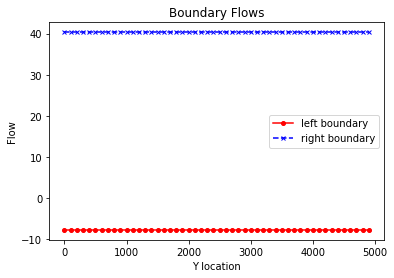

In [34]:
budgobj = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    

dummy = budgobj.list_records()

kstpkper_list = budgobj.get_kstpkper()          #returns a list of stress periods & timesteps
frf = budgobj.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff = budgobj.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells     

flux_vals=np.squeeze(frf)
leftflux = flux_vals[:,0]
rightflux = flux_vals[:,-2]

bdryflux_fig = plt.figure() 
x=np.arange(0,ncol*dx,dx) 
plt.plot(x,leftflux,marker='o', color='red', markersize=4, linestyle='-',label="left boundary")
plt.plot(x,rightflux,marker='x', color='blue', markersize=4, linestyle='--',label="right boundary")
plt.xlabel('Y location')
plt.ylabel('Flow')
plt.title("Boundary Flows")
plt.legend()
plt.show()




#### 11.2 Evaluate the head gradients

In [36]:
# head_fig = plt.figure() 
# x=np.arange(100,2600,100) 
# y=head[0,12,:]
# plt.plot(x,y,marker='o', color='mediumvioletred', markersize=4, linestyle='--')
# plt.xlabel('X location')
# plt.ylabel('Head')
# plt.title("Head along row 12")
# #plt.axvline(x=1200)

# #Save figure
# # plt.savefig('Head_Transect.png') #save figure as a png

# hgrad=(head[0,5,0]-head[0,5,-1])/Lx
# print("Head Gradient", hgrad, "m/m") 

#### 11.3 3D plot of heads

IndexError: list index out of range

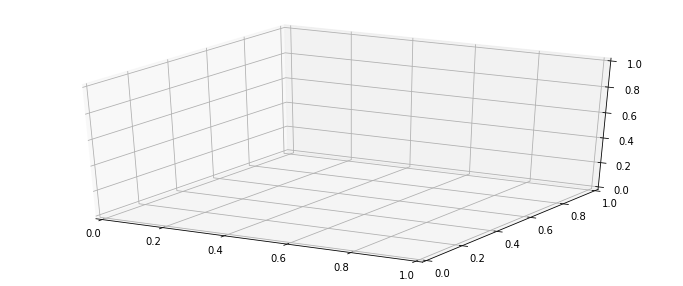

In [37]:
#create 3d figure
fig_3d = plt.figure(figsize=(12,5))
ax = fig_3d.gca(projection='3d')

#set X, Y, Z variables for 3d plot to be our model domain and head solution
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)
Z = np.flipud(head[0])

#create surface and labels
surf = ax.plot_surface(X,Y,Z, cmap = 'viridis', linewidth=0, label='head')
fig_3d.colorbar(surf,shrink=0.5,aspect=5).set_label('Head (m)',fontsize=10,fontweight='bold')
ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
ax.set_title('Steady-State Model Head Profile', fontsize=15, fontweight='bold')
# plt.savefig('BoxModel_Surface1.png') 
#plt.show(surf)

In [38]:
#create 2d figure - note, axes relate to well being defined as layer, row, column, flux
plt.contour(head[0])
plt.xlabel("column")
plt.ylabel("row")
plt.title("Plan View Head Contours")
plt.show()

# calculate linear head drop (no pumping)
bkgnd_head=np.linspace(20,10,25)
bkgnd_head=np.tile(bkgnd_head,(25,1))
plt.contour(bkgnd_head-head[0])
plt.xlabel("column")
plt.ylabel("row")
plt.title("Plan View Drawdown")
plt.show()





IndexError: list index out of range

####  11.4 Contour Head plot

IndexError: list index out of range

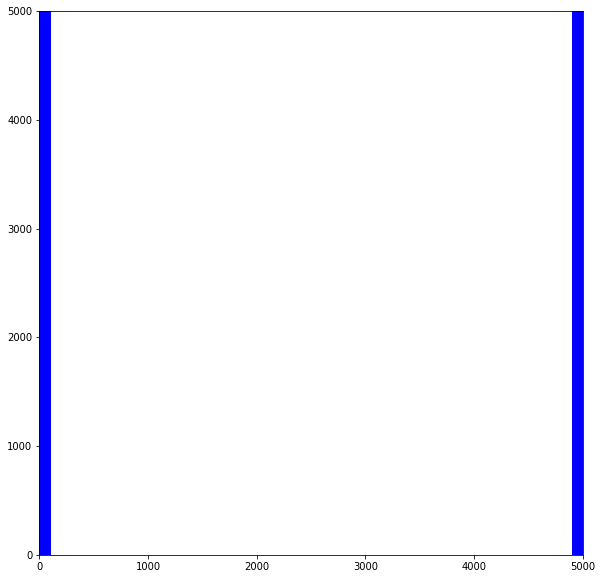

In [39]:
#plot first contour plot
fig1 = plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head[0].min(),head[0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head, levels=contour_levels) #create head contours   
flows = modelmap.plot_discharge(frf[0], fff[0], head=head) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Steady-State Model, Flow(m^3/d) and Head(m) Results', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
# plt.savefig('BoxModel_vectors.png')   
#plt.show(modelmap)